# Working with misaligned data

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/307-working_with_misaligned_data.ipynb)

This notebook contains the examples of working with misaligned data.

**Table of contents**

* [Loading data](#chapter1)
* [Preparing data](#chapter2)
    * [Using TSDataset.create_from_misaligned](#section_2_1)
    * [Using infer_alignment](#section_2_2)
    * [Using apply_alignment](#section_2_3)
    * [Using make_timestamp_df_from_alignment](#section_2_4)
* [Examples with regular data](#chapter3)
    * [Forecasting with CatBoostMultiSegmentModel](#section_3_1)
    * [Utilizing old data with CatBoostMultiSegmentModel](#section_3_2)
    * [Forecasting with ProphetModel](#section_3_3)
* [Working with irregular data](#chapter4)

In [1]:
!pip install "etna[prophet]" -q

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd

from etna.analysis import plot_backtest
from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import CatBoostMultiSegmentModel
from etna.models import ProphetModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import FourierTransform
from etna.transforms import HolidayTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import LogTransform
from etna.transforms import MeanTransform
from etna.transforms import SegmentEncoderTransform

In [4]:
HORIZON = 14

## 1. Loading data <a class="anchor" id="chapter1"></a>

Let's start by loading data with multiple segments.

In [5]:
df = pd.read_csv("data/example_dataset.csv", parse_dates=["timestamp"])
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


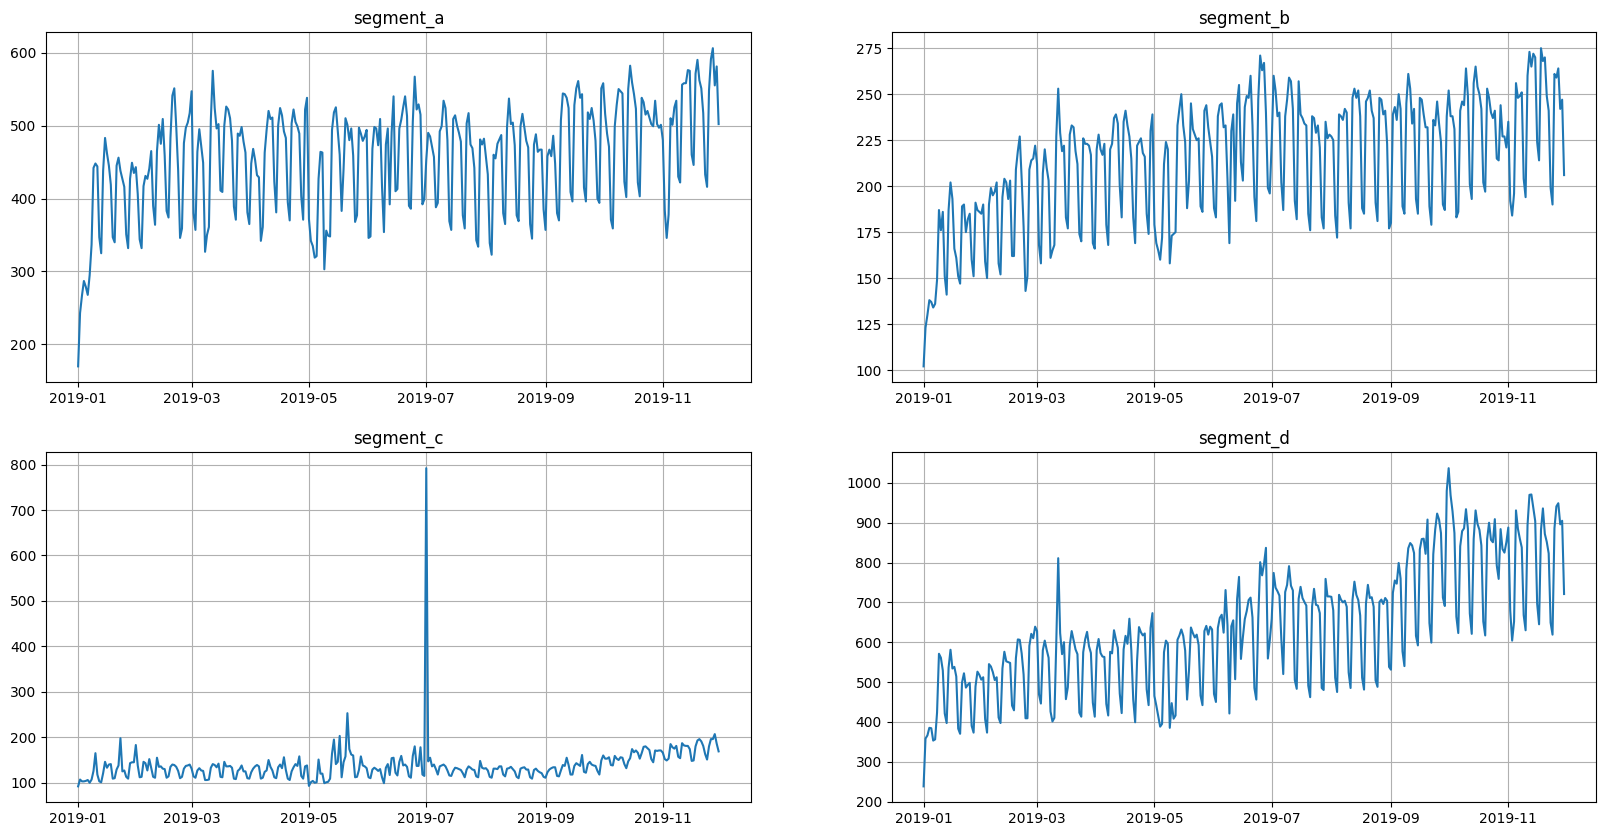

In [6]:
ts = TSDataset(df, freq="D")
ts.plot()

This data is aligned, but we need a misaligned data to make a demonstration. So, let's shift the segments.

In [7]:
df.loc[df["segment"] == "segment_b", "timestamp"] -= pd.Timedelta("365D")
df.loc[df["segment"] == "segment_c", "timestamp"] -= pd.Timedelta("730D")
df.loc[df["segment"] == "segment_d", "timestamp"] -= pd.Timedelta("1095D")

Now data is misaligned.

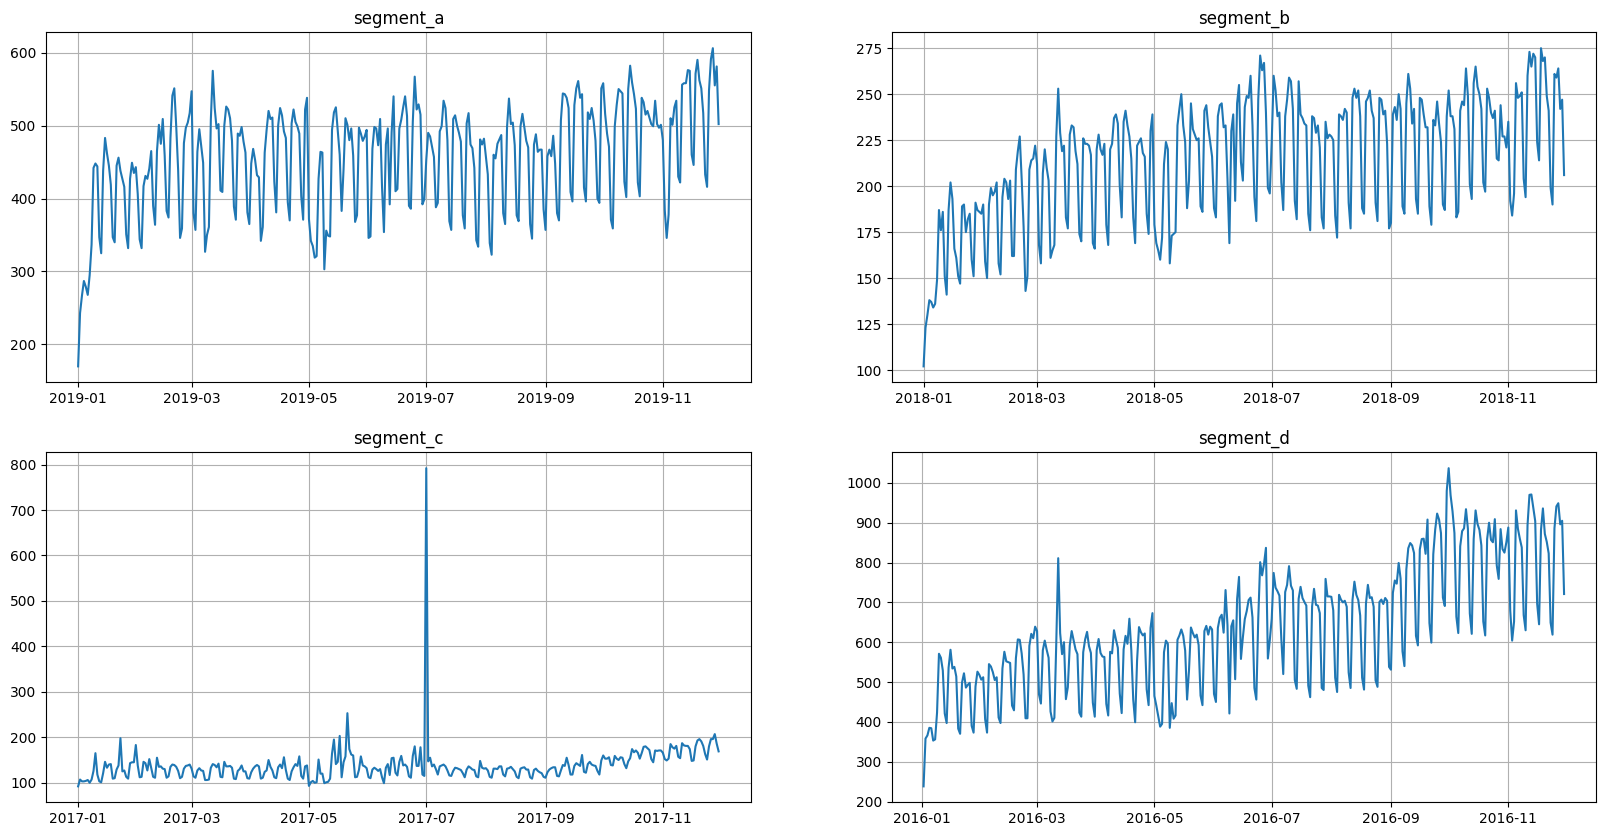

In [8]:
ts_ma = TSDataset(df=df, freq="D")
ts_ma.plot()

## 2. Preparing data <a class="anchor" id="chapter2"></a>

Our library by design works only with aligned data, so in order to support handling misaligned data we introduced the support of **integer timestamp**.

The idea is simple: if you have misaligned data you should create an integer timestamp that aligns times series with each other and then pass original timestamp as exogenous feature. In order to do all of this we added **special utilities**.

### 2.1 Using `TSDataset.create_from_misaligned` <a class="anchor" id="section_2_1"></a>

The most simple way to prepare data is to use a special constructor for `TSDataset`: `TSDataset.create_from_misaligned`. 

Let's try it out

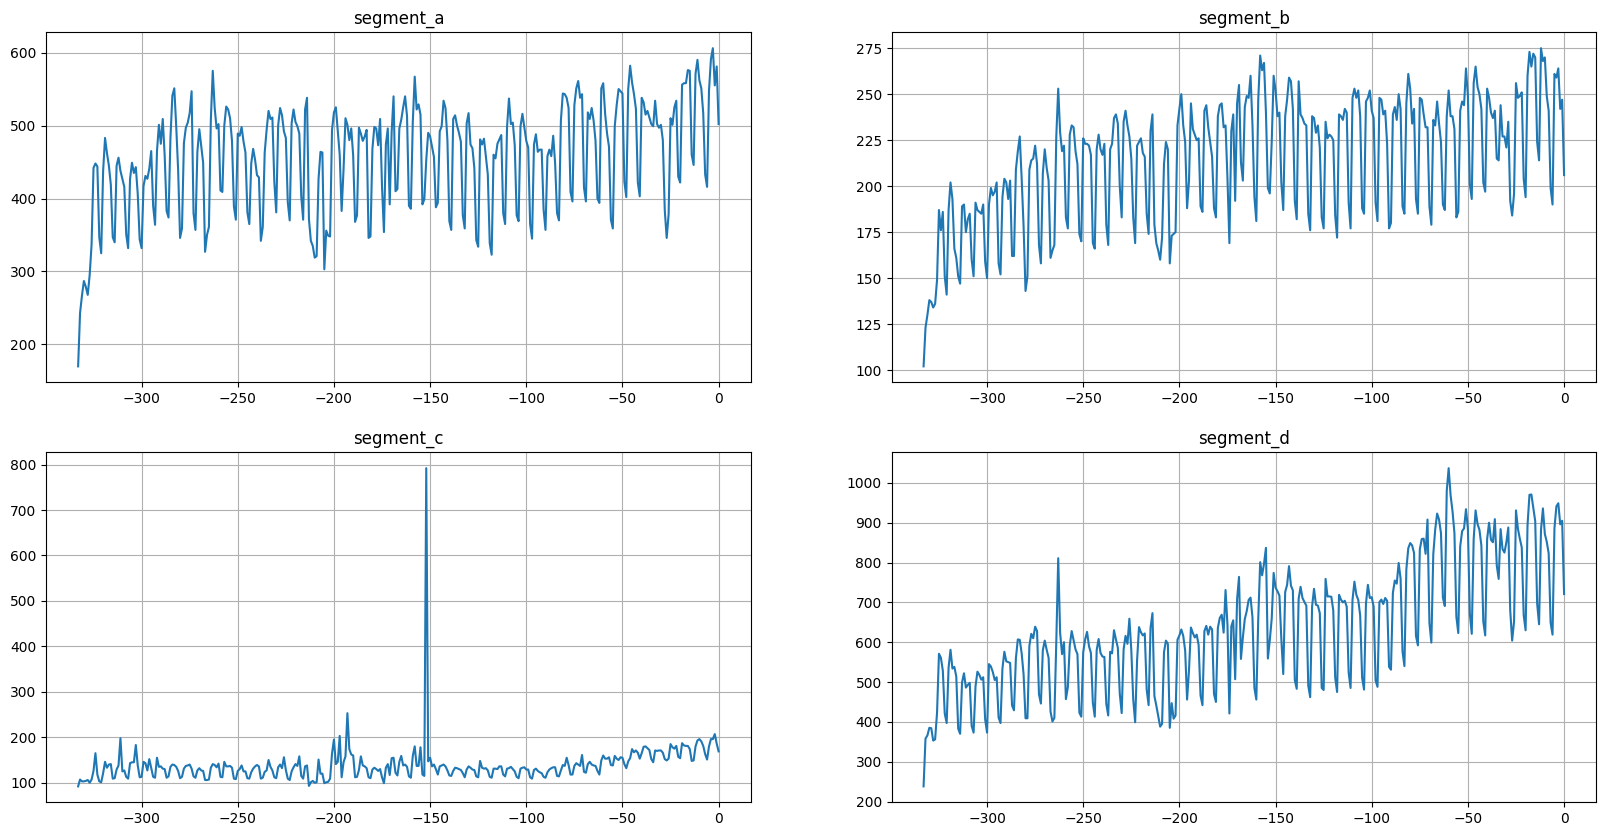

In [9]:
ts = TSDataset.create_from_misaligned(df=df, freq="D", future_steps=HORIZON)
ts.plot()

As we can see, now our time series are aligned by integer timestamp. There are few points to note:
- Parameter `df` is expected to be in a long format.
- The alignment is determined by the last timestamp for each segment. Last timestamp is taken without checking is `target` value missing or not.

Let's look at `ts` to check the presence of original timestamp:

In [10]:
ts.to_pandas()

segment            segment_a                 segment_b         \
feature   external_timestamp target external_timestamp target   
timestamp                                                       
-333              2019-01-01    170         2018-01-01    102   
-332              2019-01-02    243         2018-01-02    123   
-331              2019-01-03    267         2018-01-03    130   
-330              2019-01-04    287         2018-01-04    138   
-329              2019-01-05    279         2018-01-05    137   
...                      ...    ...                ...    ...   
-4                2019-11-26    591         2018-11-26    259   
-3                2019-11-27    606         2018-11-27    264   
-2                2019-11-28    555         2018-11-28    242   
-1                2019-11-29    581         2018-11-29    247   
 0                2019-11-30    502         2018-11-30    206   

segment            segment_c                 segment_d         
feature   external_timestamp target external_timestamp target  
timestamp                                                      
-333              2017-01-01     92         2016-01-02    238  
-332              2017-01-02    107         2016-01-03    358  
-331              2017-01-03    103         2016-01-04    366  
-330              2017-01-04    103         2016-01-05    385  
-329              2017-01-05    104         2016-01-06    384  
...                      ...    ...                ...    ...  
-4                2017-11-26    196         2016-11-26    941  
-3                2017-11-27    196         2016-11-27    949  
-2                2017-11-28    207         2016-11-28    896  
-1                2017-11-29    186         2016-11-29    905  
 0                2017-11-30    169         2016-11-30    721  

[334 rows x 8 columns]

The column with original timestamp is named `external_timestamp`, you could change the name by using a parameter named `original_timestamp_name` of `TSDataset.create_from_misaligned`. 

The feature `external_timestamp` is a regressor and it is extended into the future by `future_steps` steps.

### 2.2 Using `infer_alignment` <a class="anchor" id="section_2_2"></a>

In addition to using `TSDataset.create_from_misaligned` we could also use a more specific utilities and repeat the creation of `ts` from misaligned data.

First, we should infer the alignment used in our data. For this we should use `etna.datasets.infer_alignment`.

In [11]:
from etna.datasets import infer_alignment

alignment = infer_alignment(df)
alignment

{'segment_a': Timestamp('2019-11-30 00:00:00'),
 'segment_b': Timestamp('2018-11-30 00:00:00'),
 'segment_c': Timestamp('2017-11-30 00:00:00'),
 'segment_d': Timestamp('2016-11-30 00:00:00')}

As we can see, the last timestamp is taken for each segment. These timestamps will have the same integer timestamp after creation of `TSDataset`.

### 2.3 Using `apply_alignment` <a class="anchor" id="section_2_3"></a>

The next step is to create our integer timestamp by using `etna.datasets.apply_alignment`.

In [12]:
from etna.datasets import apply_alignment

df_aligned = apply_alignment(df=df, alignment=alignment, original_timestamp_name="external_timestamp")
df_aligned.head()

,external_timestamp,segment,target,timestamp
0,2019-01-01,segment_a,170,-333
1,2019-01-02,segment_a,243,-332
2,2019-01-03,segment_a,267,-331
3,2019-01-04,segment_a,287,-330
4,2019-01-05,segment_a,279,-329


As we can see, the original timestamp is saved under `external_timestamp` name. We don't really need it, because we want it to be extended into the future.

In [13]:
df_aligned = apply_alignment(df=df, alignment=alignment)
df_aligned.head()

,timestamp,segment,target
0,-333,segment_a,170
1,-332,segment_a,243
2,-331,segment_a,267
3,-330,segment_a,287
4,-329,segment_a,279


### 2.4 Using `make_timestamp_df_from_alignment` <a class="anchor" id="section_2_4"></a>

In order to make `external_timestamp` that extends into the future we are going to use `etna.datasets.make_timestamp_df_from_alignment`.

In [14]:
from etna.datasets import make_timestamp_df_from_alignment

start_idx = df_aligned["timestamp"].min()
end_idx = df_aligned["timestamp"].max() + HORIZON
df_exog = make_timestamp_df_from_alignment(alignment=alignment, start=start_idx, end=end_idx, freq="D")
df_exog.head()

,segment,timestamp,external_timestamp
0,segment_a,-333,2019-01-01
1,segment_a,-332,2019-01-02
2,segment_a,-331,2019-01-03
3,segment_a,-330,2019-01-04
4,segment_a,-329,2019-01-05


As you might already guessed parameters `start` and `end` determines on which set of integer timestamps the datetime timestamp will be generated.

The only thing that remains is to create `TSDataset`. We should set `freq=None`, because now we are using integer timestamp.

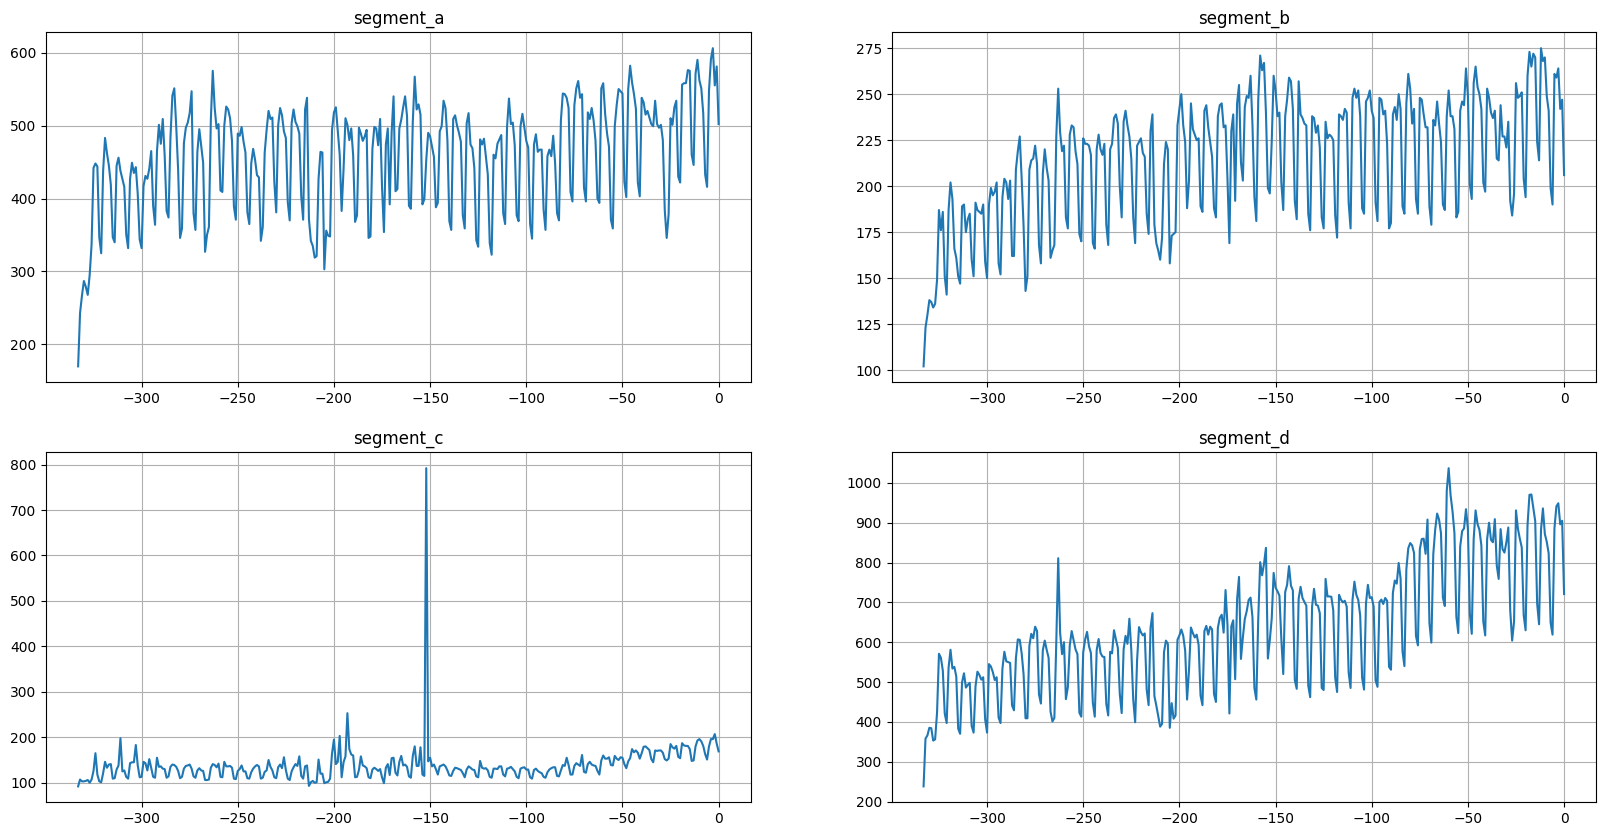

In [15]:
ts = TSDataset(df=df_aligned, df_exog=df_exog, freq=None, known_future="all")
ts.plot()

As we can see, the result is the same.

## 3. Examples with regular data <a class="anchor" id="chapter3"></a>

### 3.1 Forecasting with `CatBoostMultiSegmentModel` <a class="anchor" id="section_3_1"></a>

Let's see how to forecast misaligned data using `CatBoostMultiSegmentModel`. This model could remain unchanged compared to working with aligned data,  because it doesn't really use timestamp data and uses only features generated by transforms.

In [16]:
model = CatBoostMultiSegmentModel()

As for transforms, most of them don't need timestamp data and could remain unchanged.

In [17]:
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)

However, some transforms should be set to handle external timestamp using `in_column`.

In [18]:
date_flags = DateFlagsTransform(
    in_column="external_timestamp",
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
fourier = FourierTransform(in_column="external_timestamp", period=30, order=3, out_column="fourier_month")
is_holiday = HolidayTransform(in_column="external_timestamp", out_column="is_holiday")

In [19]:
transforms = [log, trend, lags, seg, mean, date_flags, fourier, is_holiday]

And now we are ready to run a backtest.

In [20]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [21]:
list_forecast_ts = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=3)["list_forecast_ts"]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   12.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   18.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   18.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


Let's plot the results

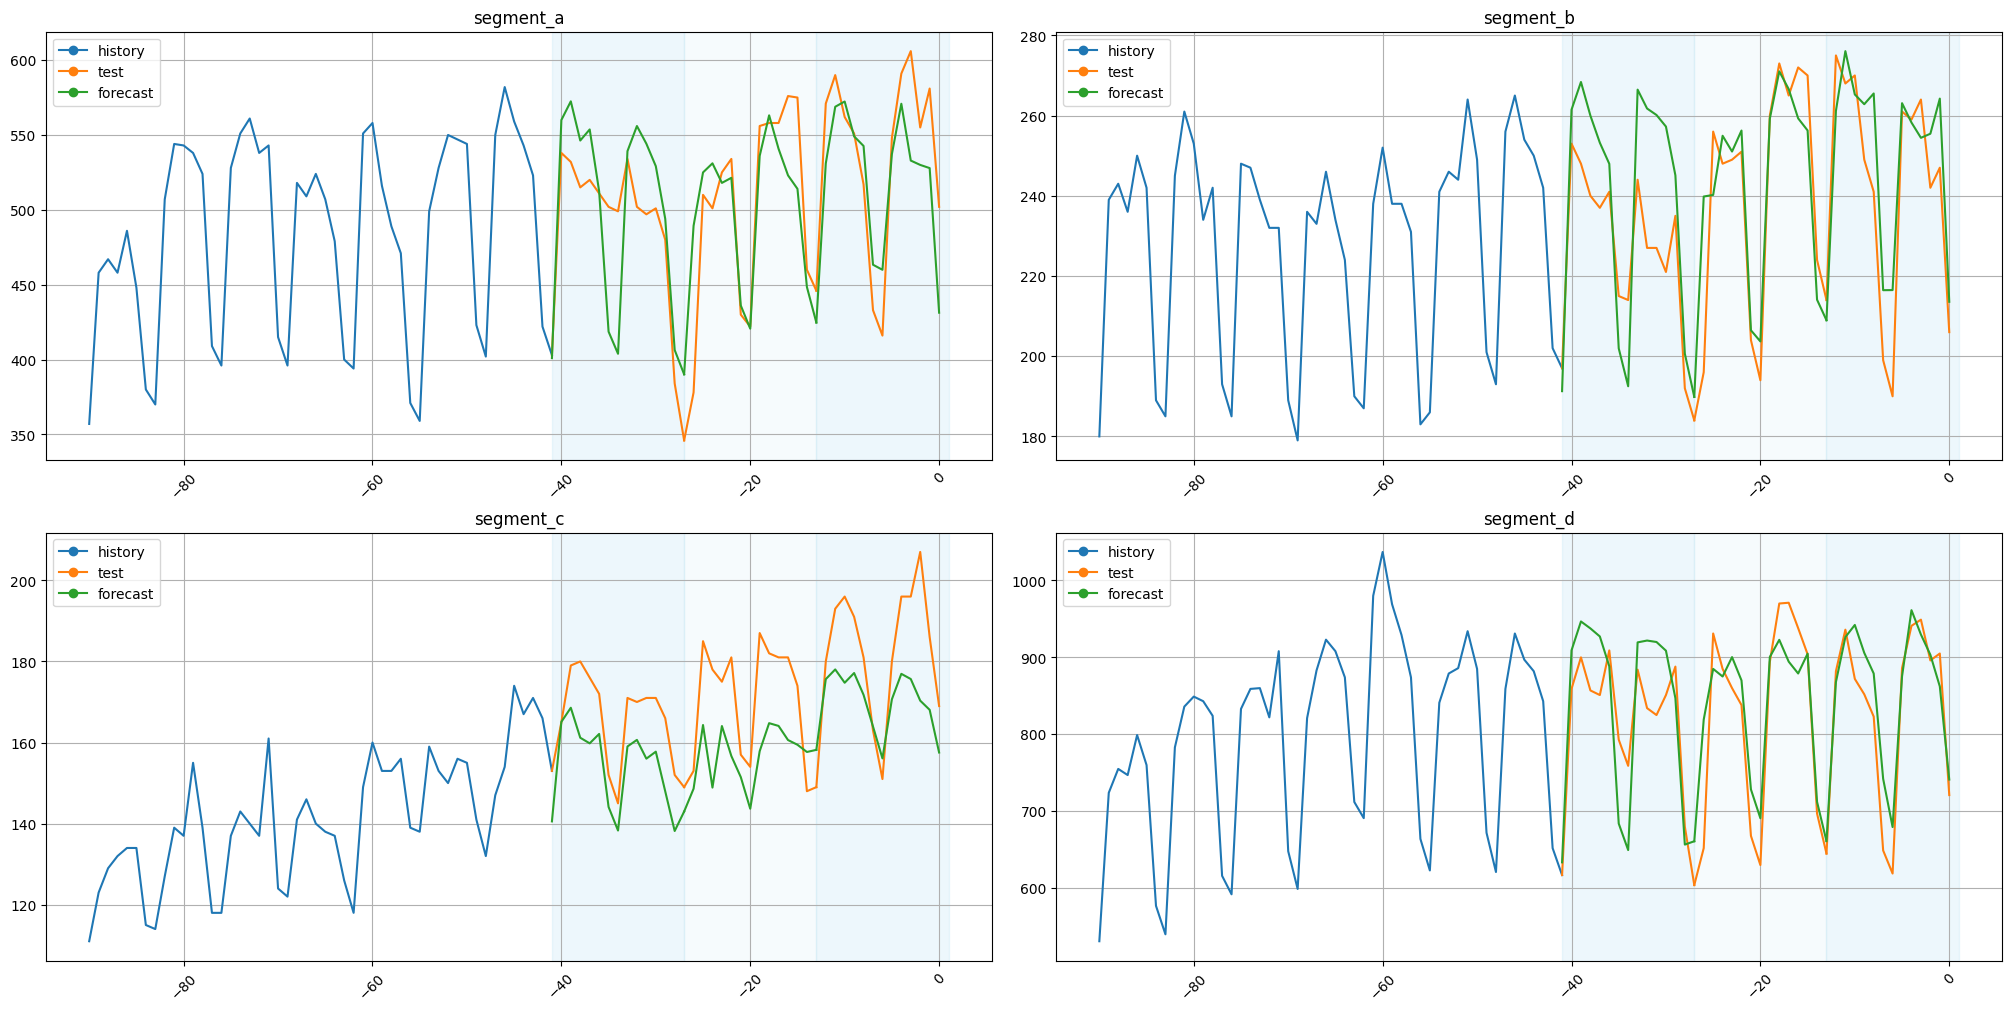

In [22]:
plot_backtest(list_forecast_ts=list_forecast_ts, ts=ts, history_len=50)

As we can see, the results are fine. The original timestamps can be found in our `forecast_df` or recreated using `make_timestamp_df_from_alignment`.

### 3.2 Utilizing old data with `CatBoostMultiSegmentModel` <a class="anchor" id="section_3_2"></a>

Imagine a scenario when we have a set of segments. Some of them are old and finished long time ago. Some of them are still relevant and we want to forecast them. However, we still want to utilize finished segments for training. 

This request can be fulfilled by handling all data as misaligned. Old segments are realigned to relevant ones and the pipeline is fitted on all of them. After that we run forecast only on subset of segments.

Let's look at our `ts_ma` once again.

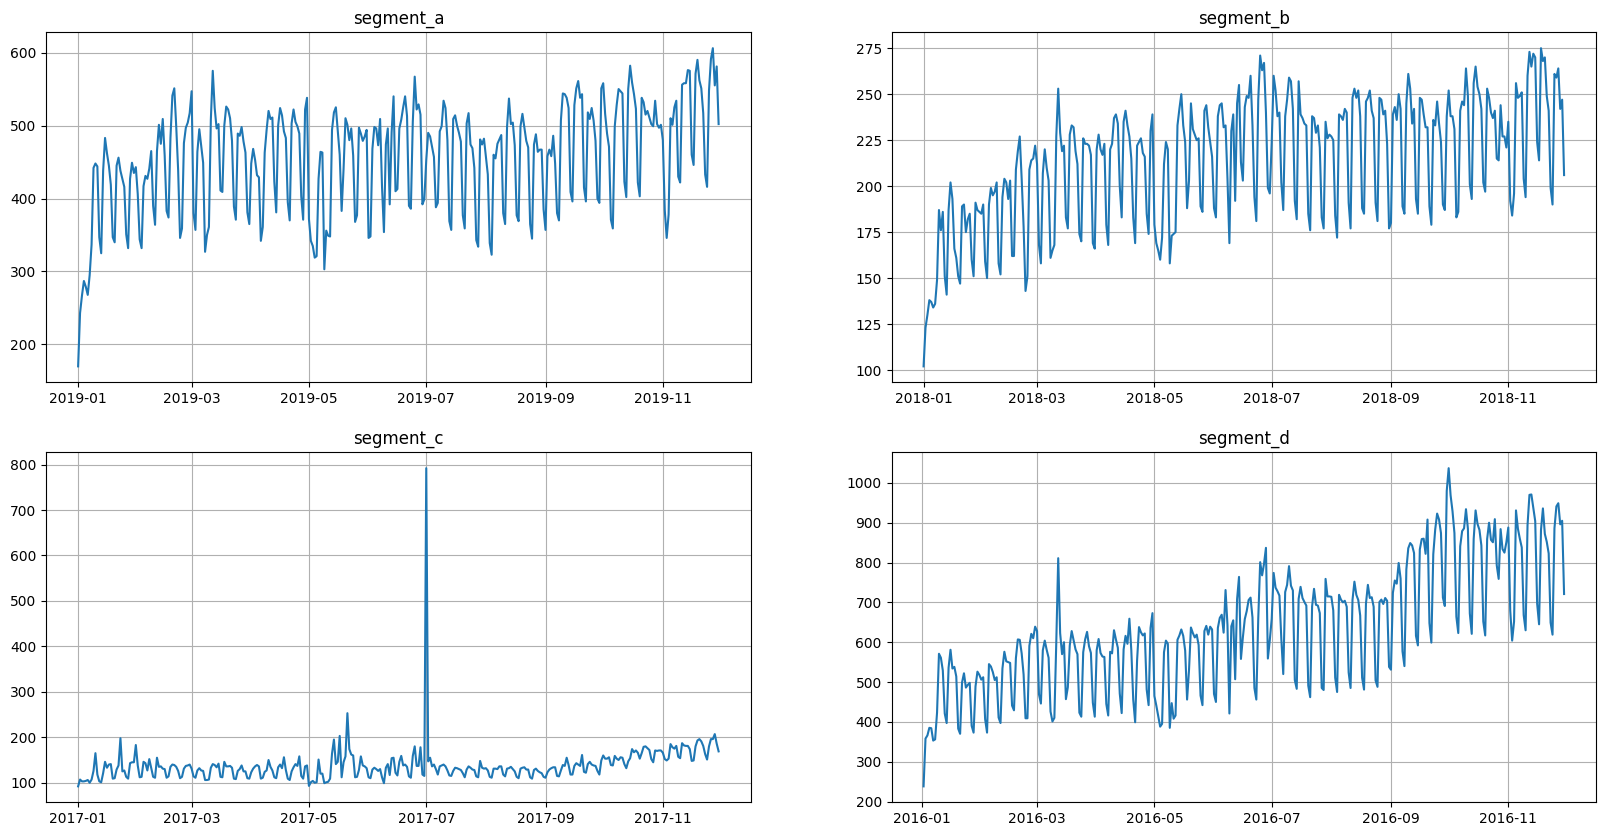

In [23]:
ts_ma.plot()

There are 4 segments, but the `segment_a` is the most recent. Let's say that other 3 segments are old and shouldn't be forecasted.

Now we are going to compare two approaches:
- Fitting model only on `segment_a`.
- Fitting model on all 4 segments and then forecasting only `segment_a`.

Let's get the metrics for the first approach.

In [24]:
cur_df = df_aligned[df_aligned["segment"] == "segment_a"]
cur_df_exog = df_exog[df_exog["segment"] == "segment_a"]
ts_segment_a = TSDataset(df=cur_df, df_exog=cur_df_exog, freq=None, known_future="all")

In [25]:
model = CatBoostMultiSegmentModel()
transforms = [log, trend, lags, seg, mean, date_flags, fourier, is_holiday]
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [26]:
metrics_df_1 = pipeline.backtest(ts=ts_segment_a, metrics=[SMAPE()], n_folds=5)["metrics_df"]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   12.7s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   17.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   22.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   22.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [27]:
metrics_df_1

,segment,SMAPE,fold_number
0,segment_a,4.073092,0
0,segment_a,4.219584,1
0,segment_a,5.831502,2
0,segment_a,5.488206,3
0,segment_a,6.950903,4


In [28]:
print(f"SMAPE for the approach 1: {metrics_df_1['SMAPE'].mean():.3f}")

SMAPE for the approach 1: 5.313


Let's get the metrics for the second approach. 

We are going to use a simplified implementation when backtest is also computed on old segments. If we want to use data more efficiently we should impleent backtest manually and use full length of the old segments at each iteration.

In [29]:
metrics_df_2 = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=5)["metrics_df"]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   17.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   24.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   34.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   34.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [30]:
metrics_df_2 = metrics_df_2[metrics_df_2["segment"] == "segment_a"]
metrics_df_2

,segment,SMAPE,fold_number
0,segment_a,4.848301,0
0,segment_a,2.898708,1
0,segment_a,6.978948,2
0,segment_a,5.924106,3
0,segment_a,6.232578,4


In [31]:
print(f"SMAPE for the approach 1: {metrics_df_2['SMAPE'].mean():.3f}")

SMAPE for the approach 1: 5.377


As we can see, these results are better.

### 3.3 Forecasting with `ProphetModel` <a class="anchor" id="section_3_3"></a>

However, not all models remain unchanged on working with unaligned data, e.g. for `ProphetModel` we should also pass a parameter `timestamp_column` to work. Let's look at it.

In [32]:
model = ProphetModel(timestamp_column="external_timestamp")
pipeline = Pipeline(model=model, transforms=[], horizon=HORIZON)

In [33]:
list_forecast_ts = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=3)["list_forecast_ts"]

14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:24 - cmdstanpy - INFO - Chain [1] done processing
14:21:24 - cmdstanpy - INFO - Chain [1] start processing
14:21:24 - cmdstanpy - INFO - Chain [1] done processing
14:21:24 - cmdstanpy - INFO - Chain [1] start processing
14:21:24 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 task

Let's plot the results.

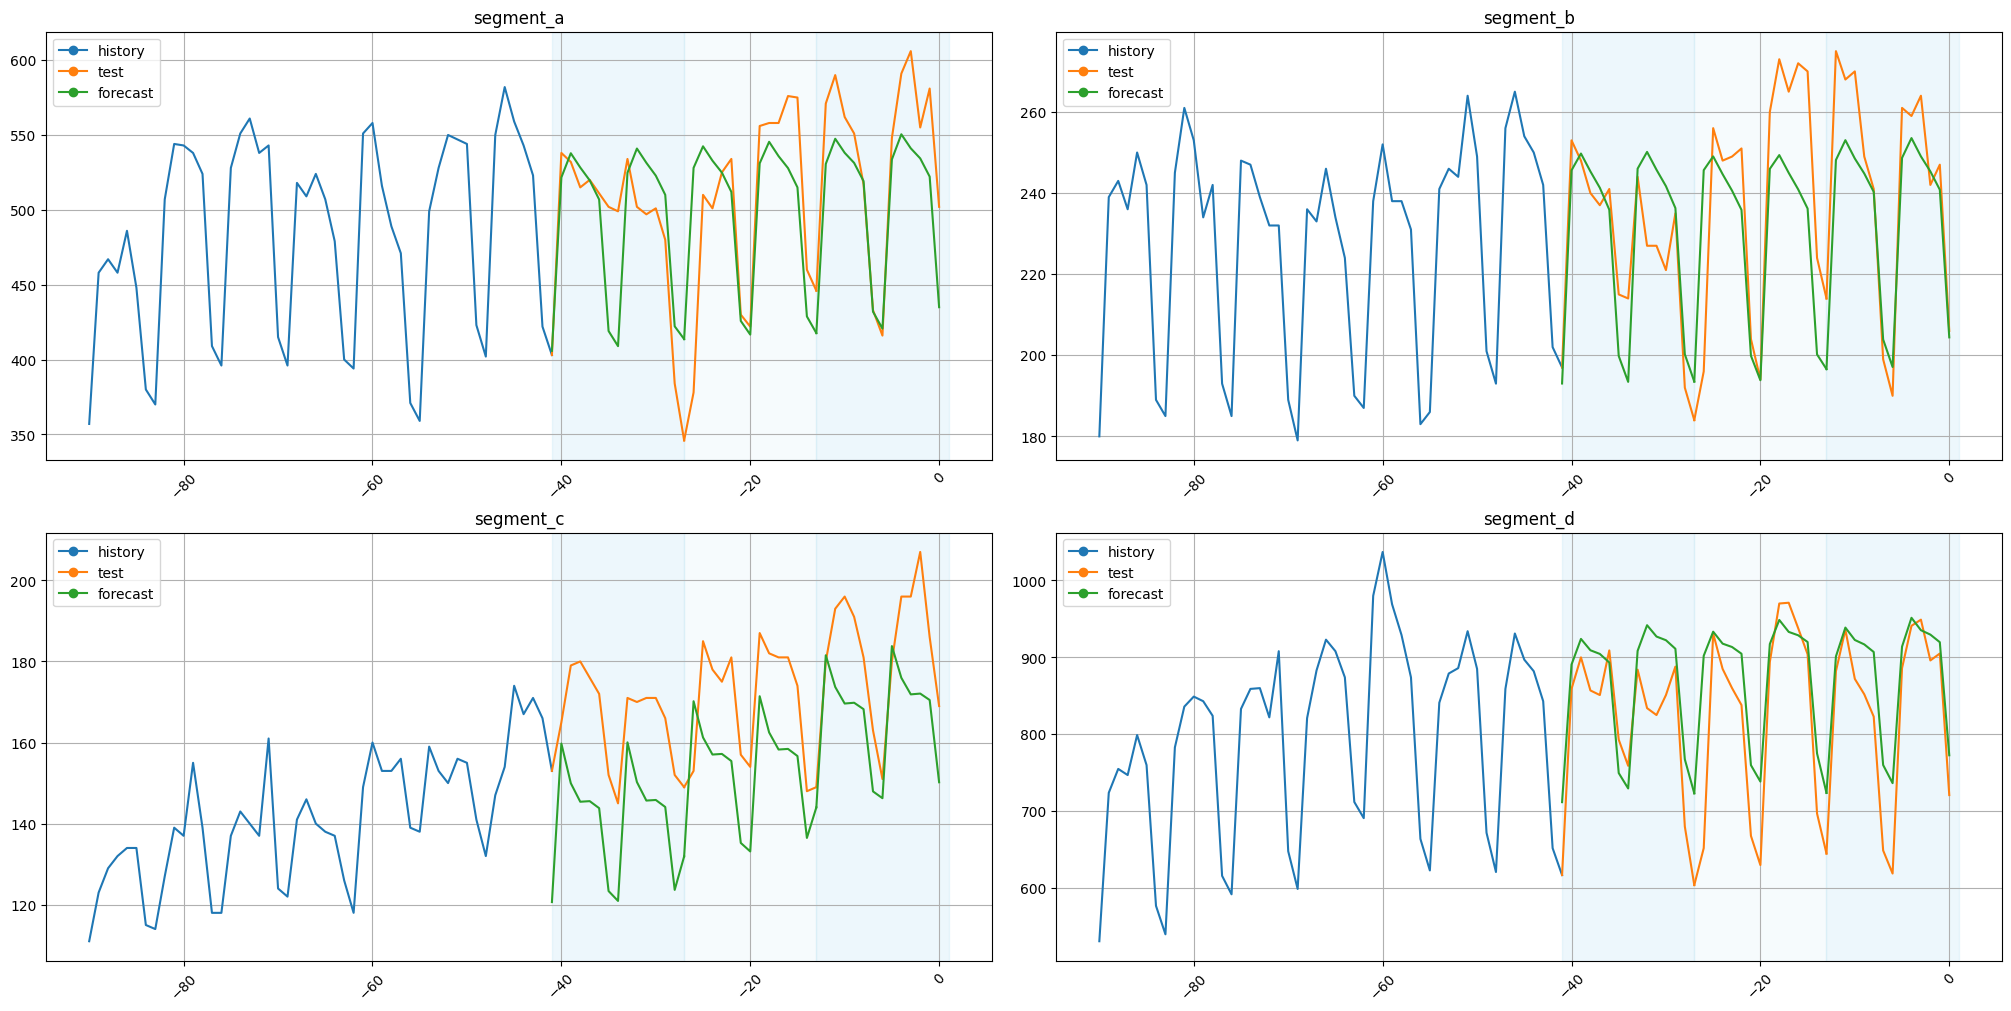

In [34]:
plot_backtest(list_forecast_ts=list_forecast_ts, ts=ts, history_len=50)

The results are fine.

## 4. Working with irregular data <a class="anchor" id="chapter4"></a>

The explained mechanism of using integer timestamp could also potentially be used to work with irregular data where there is no specific frequency. 

However, not all transforms and models can work properly in such cases, and we haven't properly tested this behavior. So, you should be very careful if trying to do this.

Let's make a little demonstration. First, we are going to load some dataset with regular data.

In [35]:
df = pd.read_csv("data/monthly-australian-wine-sales.csv")
df["timestamp"] = pd.to_datetime(df["month"])
df["num_timestamp"] = np.arange(len(df))
df["target"] = df["sales"]
df.drop(columns=["month", "sales"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,num_timestamp,target,segment
0,1980-01-01,0,15136,main
1,1980-02-01,1,16733,main
2,1980-03-01,2,20016,main
3,1980-04-01,3,17708,main
4,1980-05-01,4,18019,main


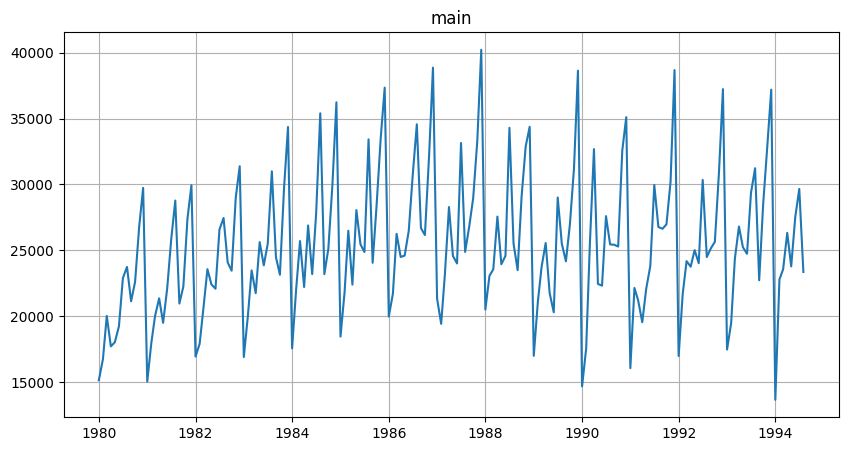

In [36]:
TSDataset(df, freq="MS").plot()

Now we'll make it irregular by removing about 50% of data.

In [37]:
rng = np.random.default_rng(0)
selected_indices = rng.choice(np.arange(len(df)), replace=False, size=len(df) // 2)
df = df.iloc[selected_indices]

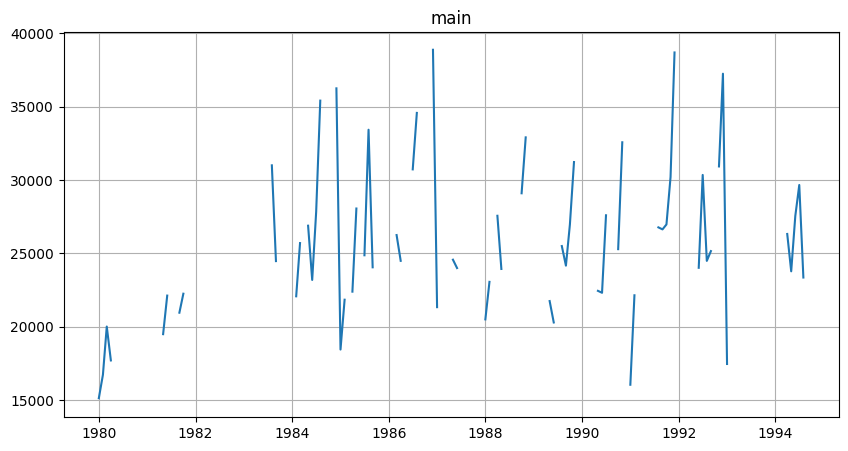

In [38]:
TSDataset(df, freq="MS").plot()

Now let's create `TSDataset` from remaining data.

In [39]:
alignment = infer_alignment(df)
alignment

{'main': Timestamp('1994-08-01 00:00:00')}

In [40]:
df_aligned = apply_alignment(df=df, alignment=alignment, original_timestamp_name="external_timestamp")
df_aligned.head()

,external_timestamp,num_timestamp,target,segment,timestamp
0,1980-01-01,0,15136,main,-87
1,1980-02-01,1,16733,main,-86
2,1980-03-01,2,20016,main,-85
3,1980-04-01,3,17708,main,-84
7,1980-08-01,7,23739,main,-83


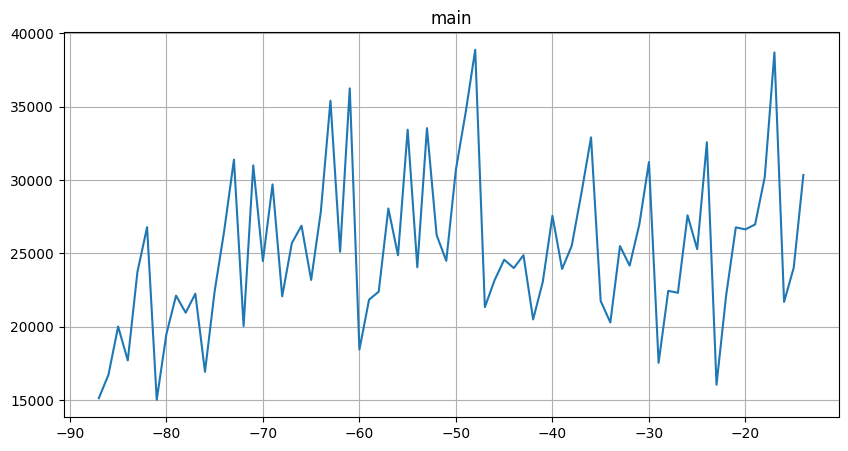

In [41]:
cur_df = df_aligned[["timestamp", "segment", "target"]]
cur_df_exog = df_aligned[["timestamp", "segment", "external_timestamp", "num_timestamp"]]

ts = TSDataset(df=cur_df.iloc[:-HORIZON], df_exog=cur_df_exog, freq=None, known_future="all")
ts.plot()

We haven't included the last value in `df` to make `external_timestamp` a valid regressor.

Let's create a forecasting pipeline.

In [42]:
model = CatBoostMultiSegmentModel()

In [43]:
log = LogTransform(in_column="target")
date_flags = DateFlagsTransform(
    in_column="external_timestamp",
    day_number_in_week=False,
    day_number_in_month=False,
    week_number_in_month=False,
    week_number_in_year=False,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
fourier = FourierTransform(in_column="num_timestamp", period=12, order=3, out_column="fourier_year")

transforms = [log, date_flags, fourier]

In [44]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

Running a backtest.

In [45]:
list_forecast_ts = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=3)["list_forecast_ts"]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


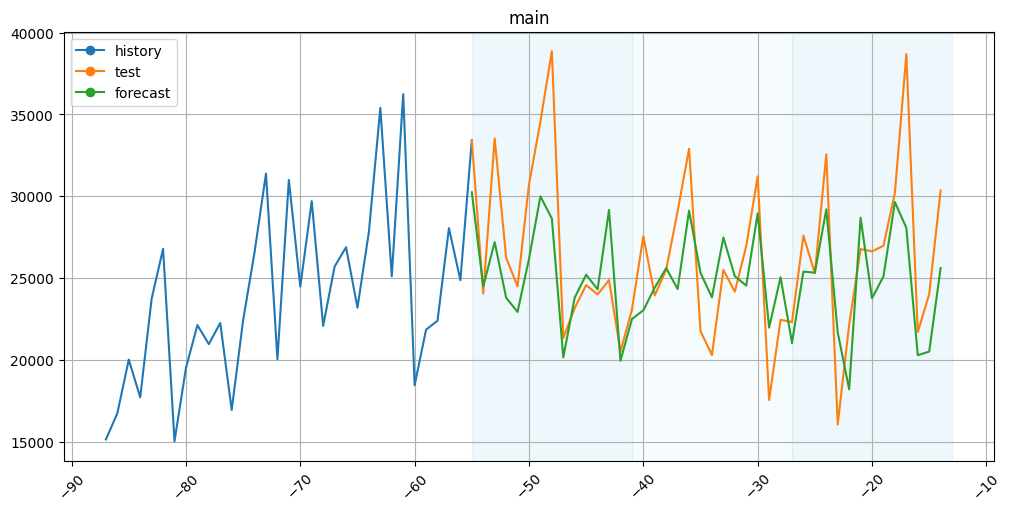

In [46]:
plot_backtest(list_forecast_ts=list_forecast_ts, ts=ts, history_len=50)

The results aren't that bad.

That’s all for this notebook. More details you can find in our documentation!